# Figure 2: Radial profiles for SKD Electrons

This notebook reproduces **Figure 2** from the paper  
**"Kinetic-based macro-modeling of the solar wind at large heliocentric distances: Kappa electrons at the exobase"**  
(submitted to *JGR–Space Physics*).

Boundary values at the exobase *y_exact_skd* and *phi_exact_skd* are obtained from our exact (numerical) solutions, see Figure 1.

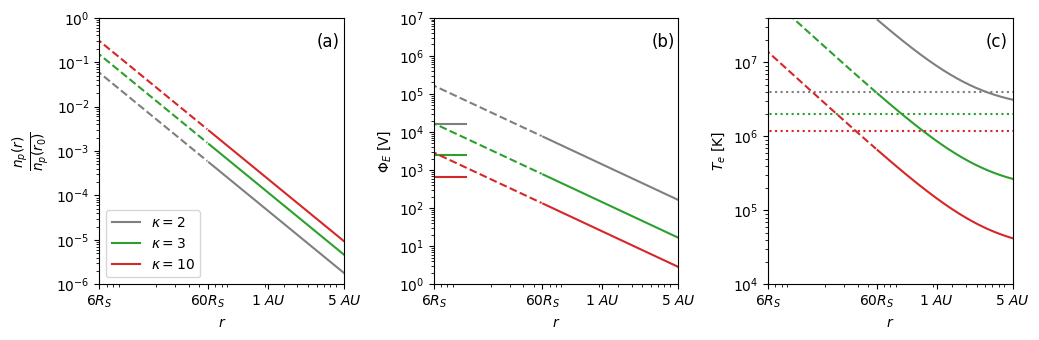

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special, constants
from scipy.special import erfcx, gamma, erf, betainc

# --- Physical constants ---
kB = constants.Boltzmann        # Boltzmann constant [J/K]
m_e = constants.m_e             # Electron mass [kg]
m_p = constants.m_p             # Proton mass [kg]
e_charge = constants.e          # Elementary charge [C]
G = 6.674e-11                   # Gravitational constant [SI]
R_sun = 6.957e8                 # Solar radius [m]
M_sun = 1.989e30                # Solar mass [kg]
AU = 149597870.7 * 1000         # Astronomic unit [m]

# --- Temperatures (K) ---
T_e = 1e6
T_p = 2e6

# --- Thermal velocities ---
w_e2 = 2 * kB * T_e / m_e
w_p2 = 2 * kB * T_p / m_p
w_e = np.sqrt(w_e2)
w_p = np.sqrt(w_p2)

# --- Gravitational potential at solar surface ---
Phi_G = m_p * G * M_sun / (6 * R_sun)

# --- Radial grid ---
r = np.linspace(5.5*R_sun, 5 * AU, 500)
r_norm = r / R_sun   # normalize to solar radii
eta = (6 * R_sun / r) ** 2

# --- Stable P(x) using erfcx ---
def P(x):
    """
    Stable evaluation of:
    P(x) = sqrt(pi) * (0.5 - x^2) * erfcx(x) + x
    where erfcx(x) = exp(x^2) * erfc(x)
    """
    x = np.asarray(x, dtype=float)
    return np.sqrt(np.pi) * (0.5 - x**2) * erfcx(x) + x

def f_SKD(v, n_e0=1.0, Te=1e6, kappa=2.0):
    #evaluate the SKD velocity distribution function
    we = np.sqrt(2 * kB * Te / m_e)
    A_k=gamma(kappa+1)/(gamma(kappa-1/2)*gamma(3/2))
    C_SKD=n_e0/(2*np.pi)*A_k/(kappa*we**2)**(3/2)
    return C_SKD*(1.0 + v**2 / (kappa * we**2)) ** (-kappa - 1.0) 

n_p_at_r0 = 1

#______________ Boundary values SKD
kappa_values = np.asarray([2, 3, 10])
y_exact_skd = np.asarray([95.287,9.548,0.756])
phi_exact_skd = np.asarray([16422.4,2468.3,651.5])
V_p0_skd = np.sqrt(2/m_p*(e_charge*phi_exact_skd - Phi_G))
colors = ["C7", "C2", "C3"]

# Create figure with 3 panels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10.5, 3.5))

# Panel 1: Density profiles
for i, (kappa_val, y_exact, phi_exact, V_p0) in enumerate(zip(kappa_values, y_exact_skd, phi_exact_skd, V_p0_skd)):
    C0 = n_p_at_r0 / np.sqrt(np.pi) * P(V_p0 / w_p)
    Density = C0 * eta
    r_norm = r / R_sun
    mask = r_norm < 60
    
    ax1.plot(r_norm[mask], Density[mask], linestyle="--", color=colors[i])
    ax1.plot(r_norm[~mask], Density[~mask], linestyle="-", color=colors[i],
             label=fr"$\kappa={kappa_val}$")
    
ax1.legend()
ax1.set_ylabel(r"$\frac{n_{p}(r)}{n_{p}(r_0)}$",fontsize=14)
ax1.set_xscale("log")
ax1.set_yscale("log")

AU_in_Rsun = AU / R_sun
xticks_vals = [6, 60, AU_in_Rsun, 5*AU_in_Rsun]
xticks_labels = [r"$6R_S$", r"$60R_S$", r"$1\ AU$", r"$5\ AU$"]
ax1.set_xticks(xticks_vals)
ax1.set_xticklabels(["","","",""])
ax1.set_xlim(6, 5*AU_in_Rsun)
ax1.set_ylim(1e-6, 1)
ax1.text(0.89, 0.89, "(a)", transform=ax1.transAxes, fontsize=12)
ax1.set_xticklabels(xticks_labels)
ax1.set_xlabel(r"$r$") 

# Panel 2: Electrostatic potential
for i, (kappa_val, y_exact, phi_exact, V_p0) in enumerate(zip(kappa_values, y_exact_skd, phi_exact_skd, V_p0_skd)):
    mask2 = r_norm < 12

    C0 = n_p_at_r0 / np.sqrt(np.pi) * P(V_p0 / w_p)
    V0 = np.sqrt(2*e_charge*phi_exact/m_e)

    ne0 = n_p_at_r0 / (1 - 1/2 * special.betainc(kappa_val - 0.5, 1.5 , 1/(1+y_exact)))
    
    D0=4*np.pi/3*f_SKD(V0, n_e0=ne0 ,Te=T_e, kappa=kappa_val)

    A_k=gamma(kappa_val+1)/(gamma(kappa_val-1/2)*gamma(3/2))

    B0=ne0/2*(1+y_exact)**(-kappa_val-1/2)*(kappa_val*y_exact+1/2)
    
    # Phi radial profile
    Phi_E_radial_profile_new = m_e * (eta * (C0 - B0) / D0) ** (2 / 3) / (2 * e_charge)

    ax2.plot(r_norm[mask], Phi_E_radial_profile_new[mask], linestyle="--", color=colors[i])
    ax2.plot(r_norm[~mask], Phi_E_radial_profile_new[~mask], linestyle="-", color=colors[i],
             label=fr"$\kappa={kappa_val}$")
    
    ax2.plot(r_norm[mask2],phi_exact_skd[i]*np.ones(np.size(r_norm))[mask2], linestyle="-", color=colors[i])

ax2.set_ylabel(r"$\Phi_E$ [V]")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xticks(xticks_vals)
ax2.set_xticklabels(["","","",""])
ax2.set_xlim(6, 5*AU_in_Rsun)
ax2.set_ylim(1, 1e7)  
ax2.text(0.89, 0.89, "(b)", transform=ax2.transAxes, fontsize=12)
ax2.set_xticklabels(xticks_labels)
ax2.set_xlabel(r"$r$") 

# Panel 3: Electron temperature
for i, (kappa_val, y_exact, phi_exact, V_p0) in enumerate(zip(kappa_values, y_exact_skd, phi_exact_skd, V_p0_skd)):
    
    C0 = n_p_at_r0 / np.sqrt(np.pi) * P(V_p0 / w_p)
    V0 = np.sqrt(2*e_charge*phi_exact/m_e)
    
    D0 = 4*np.pi/3*f_SKD(V0, n_e0=ne0 ,Te=T_e, kappa=kappa_val)
    B2 = ne0/2*kappa_val*w_e**2/(2*kappa_val-3)*(1+y_exact)**(-kappa_val+1/2)*(kappa_val*y_exact+3/2)
    
    r_norm = r / R_sun
    mask = r_norm < 60

    T_43 = m_e/(5*kB) * (C0/D0)**(2/3) * eta**(2/3)
    T_C = m_e*B2/(3*kB*C0)
    Te_radial_profile = T_C + T_43

    ax3.plot(r_norm[mask], Te_radial_profile[mask], linestyle="--", color=colors[i])
    ax3.plot(r_norm[~mask], Te_radial_profile[~mask], linestyle="-", color=colors[i],
             label=fr"$\kappa={kappa_val}$")

    T_convertion_factor=kappa_val/(kappa_val-3/2)
    ax3.plot(r_norm, T_convertion_factor*T_e*np.ones(np.size(r_norm)), linestyle=":", color=colors[i])

ax3.set_ylabel(r"$T_e$ [K]")
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.axvline(6, color="gray", linestyle=":")
ax3.set_xticks(xticks_vals)
ax3.set_xticklabels(xticks_labels)
ax3.set_xlabel(r"$r$") 
ax3.set_xlim(6, 5*AU_in_Rsun)
ax3.set_ylim(1e4, 4e7)
ax3.text(0.89, 0.89, "(c)", transform=ax3.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig("Figure_2.pdf", bbox_inches="tight")
plt.show()